# Analyzing all 6 species worth of gene level data.





## Necessary Imports

In [1]:
%matplotlib notebook
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt, matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
import similaritymeasures as sm
from scipy.optimize import curve_fit

## Progress Indicator

This function allows for loading bars in for loops.

In [2]:
# I got this function from https://github.com/kuk/log-progress

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Reading Data

In [3]:
# These are the CSV file paths for each species:
csvs = [
    'data/gene_level/DC10_GL_clust-smry.csv',
    'data/gene_level/DC30_GL_clust-smry.csv',
    'data/gene_level/DC40_GL_clust-smry.csv',
    'data/gene_level/DC50_GL_clust-smry.csv',
    'data/gene_level/DC60_GL_clust-smry.csv',
    'data/gene_level/DC70_GL_clust-smry.csv'
]

# We only need a subset of the columns from each CSV:
columns = [
    'PanID',
    'sum_meanTPM_Ti',
    'sum_meanTPM_Tii',
    'sum_meanTPM_Tiii',
    'sum_meanTPM_Tiv', 
    'TC_qval'
]


# We make a list of data frames; one for each csv.
dfs = []

for csv in csvs:
    
    # Read CSV into dataframe. Only read some of the columns.
    df = pd.read_csv(csv, usecols=columns)
    
    # Remove rows that have missing values and/or infinite values. 
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Infer the data type of each column and cast as needed.
    df = df.infer_objects()
    
    # Append the data frame to the list of data frames.
    dfs.append(df)

## Q Value Filtering

We only care about the genes that have low Timecourse Corrected P-Values (TC_qval).
So we remove all genes from each species that have TC_qval's greater than 0.1.

In [4]:
for i in range(6):
    
    # Remove genes with high TC_qval's.
    dfs[i] = dfs[i][dfs[i]['TC_qval'] < 0.1]
    
    # We are done with the TC_qval column, so we can remove it. 
    dfs[i] = dfs[i].drop(['TC_qval'], axis = 1)

## Exploratory Plot

Each gene has expression levels given at 4 different time points. For each species we take each one of those time points and plot them. Since we can only plot in 3 dimensions, the last time point is represented as color.

<IPython.core.display.Javascript object>


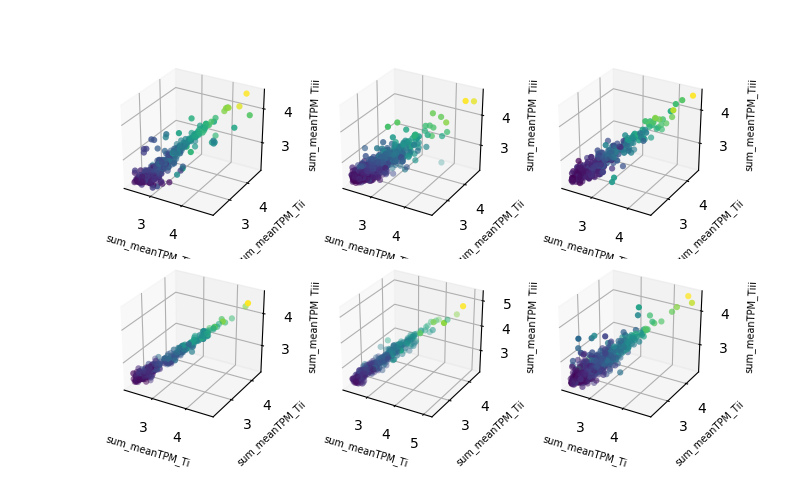

In [5]:
# Create a new figure.
fig = plt.figure(figsize=plt.figaspect(0.6))

# Plot the sum_meanTPM_T values for each dataframe.
for (i, df) in enumerate(dfs):
    
    # Extract the subplot at index (i+1) from the figure. 
    # Why are the indicies expected to not be zero indexed in the 'add_subplot' function? 
    # Thats really weird. But, whatever.
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    # Most of the data points are less than 200. I am only plotting ones larger than 200 to make the code run faster.
    x = df['sum_meanTPM_Ti'].where(df['sum_meanTPM_Ti'] > 200)
    y = df['sum_meanTPM_Tii'].where(df['sum_meanTPM_Tii'] > 200)
    z = df['sum_meanTPM_Tiii'].where(df['sum_meanTPM_Tiii'] > 200)
    r = df['sum_meanTPM_Tiv'].where(df['sum_meanTPM_Tiv'] > 200)

    # Supress massive values by taking log. 
    # Values may be massive becuase of large expression levels or misreads. 
    x = np.log10(x)
    y = np.log10(y)
    z = np.log10(z)
    r = np.log10(r)
    
    # Add data to plot.
    ax.scatter(x, y, z, c=r, cmap='viridis', linewidth=0.001);
    
    # Axis Labels
    ax.set_xlabel('sum_meanTPM_Ti', fontsize=7)
    ax.set_ylabel('sum_meanTPM_Tii', fontsize=7)
    ax.set_zlabel('sum_meanTPM_Tiii', fontsize=7)

## Normalization

This analysis just cares about how the genes expression changes over time. We don't care about how many genes are expressed at each time point. So, we normalize.

In [6]:
# Normalizes a row.
def normalize_row(row):
    return (row - row.min()) / (row.max() - row.min())    

# For each species...
for i in log_progress(range(6)):

    column_names = ['sum_meanTPM_Ti', 'sum_meanTPM_Tii', 'sum_meanTPM_Tiii', 'sum_meanTPM_Tiv']
    
    # Normalize the sum_meanTPM columns for each row.
    dfs[i][column_names] = dfs[i][column_names].apply(normalize_row, axis=1)

## Clustering

Discounting color we can see 3 distinct bands. Each one of these represents a group of genes with similar expression curves. 

These bands do not follow the good clustering principal. So it is very difficult to tease them appart. Especially when we consider the 4th dimension (color). 

So we use singular vector decomposition to reduce the dimensionality and create groups that follow the good clustering principal. 

<IPython.core.display.Javascript object>


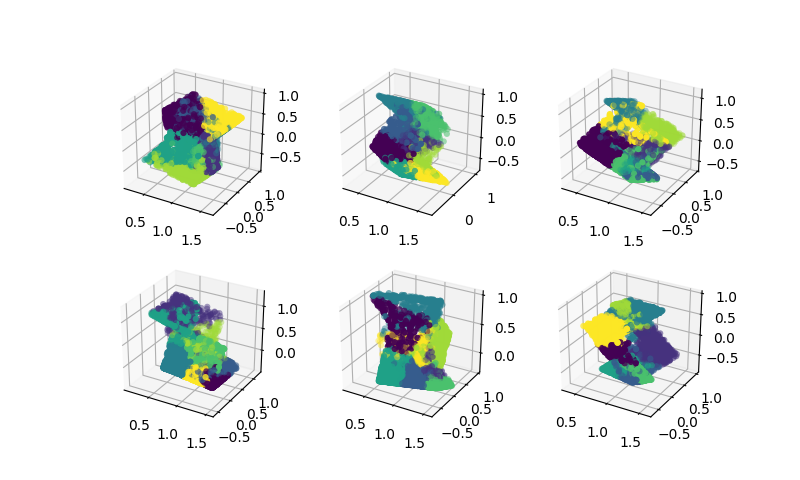

In [7]:
# Create a new figure.
fig = plt.figure(figsize=plt.figaspect(0.6))

# Cluster and plot the results for each species.
for (i, df) in enumerate(dfs):
    
    # Extract the subplot at index (i+1) from the figure. 
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    # Create a object that can perform the singular vector decomposition
    svd = TruncatedSVD(n_components=3)
    
    # We perform the singular vector decomposition.
    # This results in a 3 dimensional data set.
    column_names = ['sum_meanTPM_Ti', 'sum_meanTPM_Tii', 'sum_meanTPM_Tiii', 'sum_meanTPM_Tiv']
    reduced = svd.fit_transform(df[column_names])
    
    # Converting the result to a dataframe.
    reduced_df = pd.DataFrame(data=reduced, columns = ["x", "y", "z"])
    
    # My man Kartik Krishnan says that 8 clusters are where its at.
    pred = KMeans(n_clusters = 8).fit_predict(reduced_df)
    
    # Lets plot it. We color based off the color. 
    x = reduced_df["x"]
    y = reduced_df["y"]
    z = reduced_df["z"]
    r = pred
    ax.scatter(x, y, z, c=r, cmap='viridis', linewidth=0.001);
    
    # Add a column with cluster indicies to the each species data frame.
    df['cluster'] = pred

## Genes curves for each cluster. 

Each one of these clusters should represent genes that follow similar expression curves. We should check to make sure that is the case.

##### First, make some tidy dataframes that seaborn can use. Seaborn is very picky.

In [85]:
from multiprocessing import Process
from multiprocessing import Pool

tidy_dfs = []

for df in log_progress(dfs):

    tidy_df = pd.DataFrame()

    for index, row in df.iterrows():
        tidy_df = tidy_df.append({'PanID':row[0], 'tp':0, 'cluster':row[5], 'sum_mean_TPM':row[1]}, ignore_index = True)
        tidy_df = tidy_df.append({'PanID':row[0], 'tp':1, 'cluster':row[5], 'sum_mean_TPM':row[2]}, ignore_index = True)
        tidy_df = tidy_df.append({'PanID':row[0], 'tp':2, 'cluster':row[5], 'sum_mean_TPM':row[3]}, ignore_index = True)
        tidy_df = tidy_df.append({'PanID':row[0], 'tp':3, 'cluster':row[5], 'sum_mean_TPM':row[4]}, ignore_index = True)

    tidy_dfs.append(tidy_df)

<IPython.core.display.Javascript object>


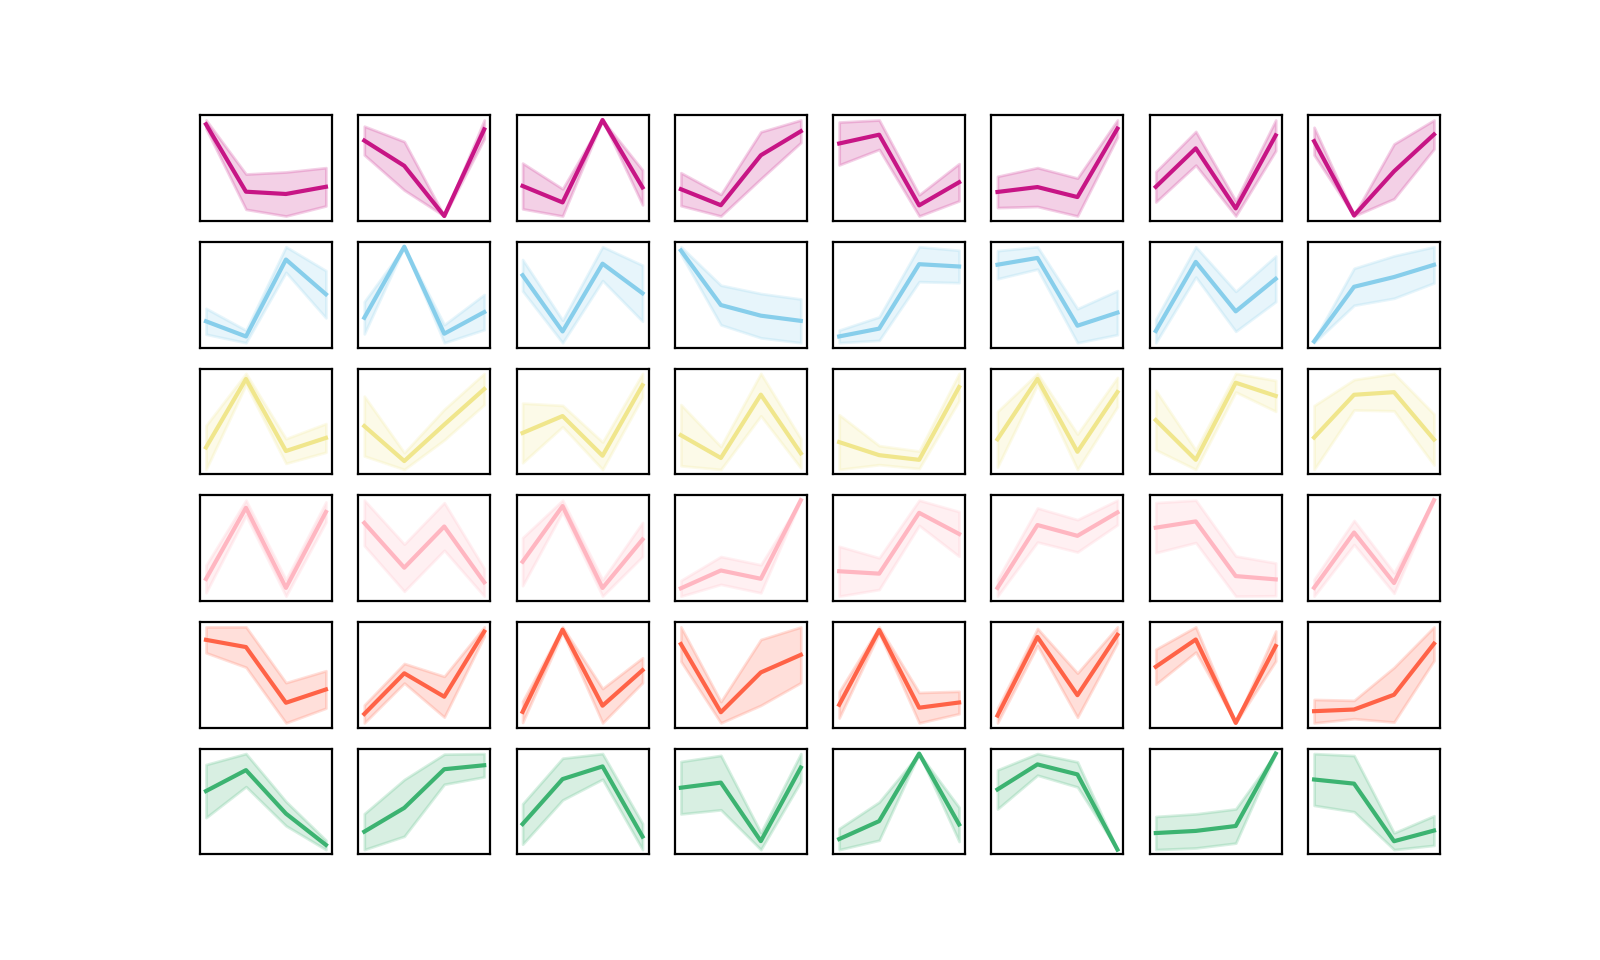

Text(0.86, 0.9, '7')

In [87]:
# Create a new figure.
fig = plt.figure(figsize=plt.figaspect(0.6))

colors = [
    'mediumvioletred',
    'skyblue',
    'khaki',
    'lightpink',
    'tomato',
    'mediumseagreen'
]

# Cluster and plot the results for each species.
for (i, tidy_df) in enumerate(tidy_dfs): # For each species...

    for j in range(8): # For each cluster...    
    
        # Extract the subplot at index (i+1) from the figure. 
        ax = fig.add_subplot(6, 8, (i * 8) + (j + 1))

        cluster_df = tidy_df[tidy_df.cluster == j]
                
        ax = sns.lineplot(x="tp", y="sum_mean_TPM", data=cluster_df, ci='sd', color=colors[i])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        
# Label Plot
fig.text(0.06, 0.16, 'DC70')
fig.text(0.06, 0.30, 'DC60')
fig.text(0.06, 0.43, 'DC50')
fig.text(0.06, 0.56, 'DC40')
fig.text(0.06, 0.69, 'DC30')
fig.text(0.06, 0.82, 'DC10')

fig.text(0.16, 0.90, '0')
fig.text(0.26, 0.90, '1')
fig.text(0.36, 0.90, '2')
fig.text(0.46, 0.90, '3')
fig.text(0.56, 0.90, '4')
fig.text(0.66, 0.90, '5')
fig.text(0.76, 0.90, '6')
fig.text(0.86, 0.90, '7')

## Fitting Each Curve

We fit each curve to a cubic function following A*x^3 + B*x^2 + C*x^1 + D. Then, we create a dataframe where the columns represent the clusters above, and the rows represent species. Each value is a list containing the fitted curve params [A,B,C,D].

<IPython.core.display.Javascript object>


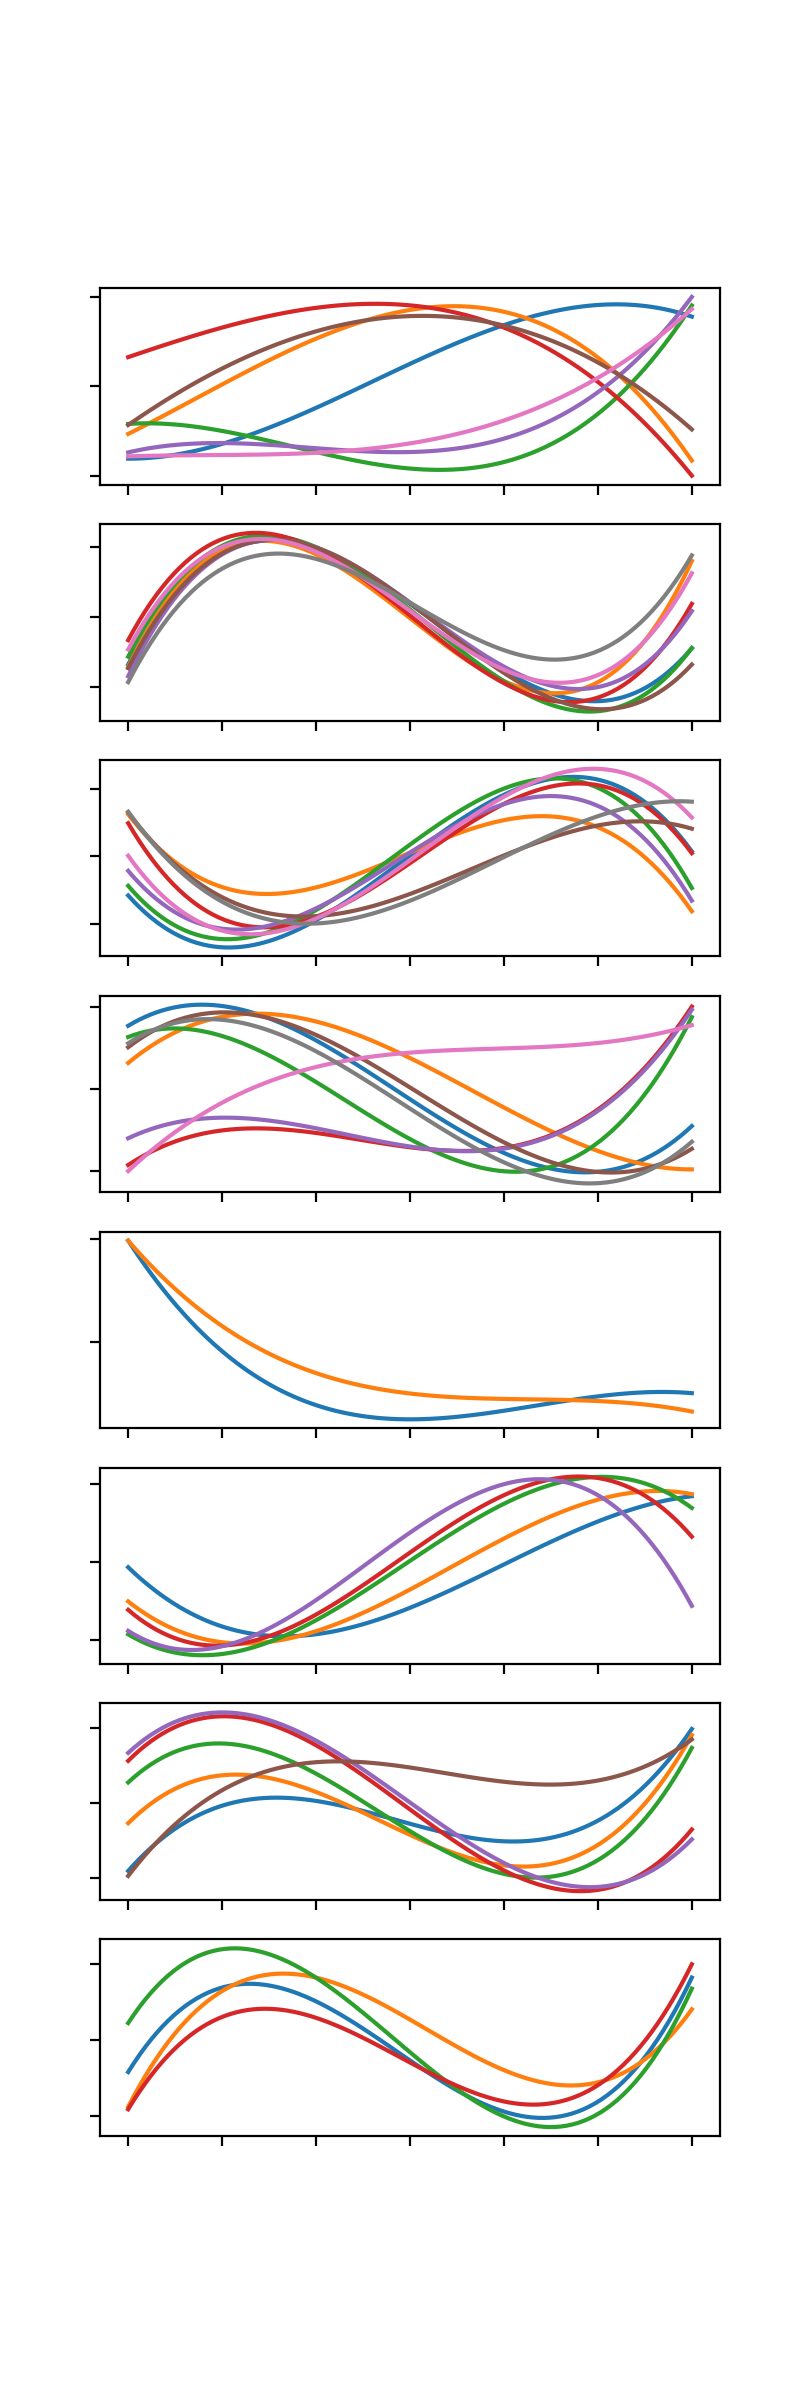

In [90]:

species = ["DC10","DC30","DC40","DC50","DC60","DC70"]

curve_params_df = pd.DataFrame(columns = ["species","cluster","a","b","c","d"])

def cubic_curve(x, a, b, c, d):
    return a*(x**3)+b*(x**2)+c*(x)+d

for j in range(8): # For each cluster...
    
    for (i, tidy_df) in enumerate(tidy_dfs): # For each species...
               
        cluster_df = tidy_df[tidy_df.cluster == j]
                
        popt, pcov = curve_fit(cubic_curve, cluster_df['tp'], cluster_df['sum_mean_TPM'])
        
        curve_params_df = curve_params_df.append({ 'species':species[i], 'cluster':j, 'a':popt[0],'b':popt[1],'c':popt[2],'d':popt[3]}, ignore_index = True)
        

pred = KMeans(n_clusters = 8).fit_predict(curve_params_df[["a","b","c","d"]])

curve_params_df["curve_cluster"] = pred

# Plotting
fig = plt.figure(figsize=plt.figaspect(3.0))

num_rows = 8
num_cols = curve_params_df["curve_cluster"].value_counts().max()

for cluster in range(8):
    
    ax = fig.add_subplot(num_rows, 1, cluster + 1)
    
    similar_df = curve_params_df[curve_params_df["curve_cluster"] == cluster]
    for index, row in similar_df.iterrows():

        xs = np.linspace(0,3,100)
        ys = cubic_curve(xs, row['a'], row['b'], row['c'], row['d'])

        ax.plot(xs,ys)    

In [120]:
res = pd.DataFrame(columns = ["PanID","curve_cluster"])

for s, species in enumerate(["DC10","DC30","DC40","DC50","DC60","DC70"]):
    print(s)
    species_tidy_df = tidy_dfs[s]
    
    test = curve_params_df[curve_params_df['species'] == species]
    
    for index, row in species_tidy_df.iterrows():
        cluster = row['cluster']
        curve_cluster = int(test[test['cluster']==cluster]['curve_cluster'])
        res = res.append({'PanID':row['PanID'], 'curve_cluster':curve_cluster}, ignore_index = True)
            

0
1
2
3
4
5


In [121]:
res.shape

(142596, 2)

In [122]:
res_no_dups = res.drop_duplicates()
res_no_dups.shape

(30603, 2)

In [123]:
res_no_dups.head()

,PanID,curve_cluster
0,PTHR10012,5
4,PTHR10013,5
8,PTHR10013:SF0,5
12,PTHR10019,7
16,PTHR10025,3
